In [1]:
!pip install emoji

     |████████████████████████████████| 170 kB 3.5 MB/s eta 0:00:01
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169294 sha256=abc0373cf37923ec60ed9d48f34fc8d1778496570631bc7bda33d5d4f9c732f2
  Stored in directory: /Users/alexisjordan/Library/Caches/pip/wheels/04/29/50/1e7189f03d2cf139e469863d54a1d3eabeb10c92c84e51f8a1
Successfully built emoji


In [2]:
!pip install streamlit

In [5]:
!pip install unidecode

     |████████████████████████████████| 235 kB 3.3 MB/s eta 0:00:01


### Imports

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import streamlit as st
from random import sample
from collections import Counter
import ast
import re
import random
import pickle
import string
import unidecode
import emoji
import matplotlib.pyplot as plt

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import roc_auc_score

In [8]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import config

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexisjordan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
np.set_printoptions(suppress=True)   # turn off scientific notation
pd.options.display.float_format = '{:.2f}'.format

### Data 

My data was scraped from bon appetit. It's one of my favorite cooking websites ever, so it's something I would actually use.

In [10]:
recipes = pd.read_csv('full_bonapp_df_clean.csv')
recipes = recipes.drop(columns=['review_text', 'review_count', 'filtered_ingreds'])

In [11]:
recipes

,Unnamed: 0,dishtitle,ingredients,instructions,published,rating,ratings_count,url
0,0,"Fish Pie with Potatoes, Leeks, Zucchini, and T...","['1½ pounds russet potatoes (about 3 medium)',...",Preheat oven to 350°. Cook potatoes in a large...,2015-02-01,3.60,14,https://www.bonappetit.com/recipe/fish-pie-wit...
1,1,Trout Roe and Turnip Toast,"['Dark rye bread', 'Cream cheese', 'Trout roe'...",Spread toasted dark rye bread with cream chees...,2015-01-01,3.00,4,https://www.bonappetit.com/recipe/trout-roe-an...
2,2,Aquavit Toddy,"['1 star anise pod', '½ teaspoon green cardamo...","Cook star anise, cardamom, and black peppercor...",2014-12-01,4.80,9,https://www.bonappetit.com/recipe/aquavit-toddy
3,3,Almond-Barley Porridge with Fruit Compote,"['½ cup sugar', '¾ cup dried cherries', ' divi...","Bring sugar, ½ cup cherries, and 1½ cups water...",2014-12-01,4.30,16,https://www.bonappetit.com/recipe/almond-barle...
4,4,Thai Celery Salad with Peanuts,"['3 tablespoons vegetable oil', '2 tablespoons...","Whisk together oil, lime juice, and fish sauce...",2014-09-01,4.31,56,https://www.bonappetit.com/recipe/thai-celery-...
...,...,...,...,...,...,...,...,...
3852,3852,Pasta with Shrimp and San Marzano Tomatoes,"['2 pounds medium shell-on shrimp', '1 tablesp...","Shell and devein shrimp, reserving shells. Cut...",2016-06-01,5.00,1,https://www.bonappetit.com/recipe/pasta-with-s...
3853,3853,Sweet and Spicy Bacon Kebabs with Scallion-Gin...,"['6 scallions', ' thinly sliced', '1 serrano c...","Toss scallions, chile, lime juice, oil, ginger...",2016-06-01,5.00,2,https://www.bonappetit.com/recipe/sweet-spicy-...
3854,3854,Mezcal Paloma,"['¼ cup fine sea salt', '1 teaspoon ground chi...",Mix salt and chile in a small bowl and spread ...,2016-06-01,NaN,0,https://www.bonappetit.com/recipe/mezcal-paloma
3855,3855,Mango-Lime Curd,"['1 ripe large mango', ' peeled', ' flesh cut ...",Process mango in a food processor until smooth...,2016-12-01,5.00,1,https://www.bonappetit.com/recipe/mango-lime-curd


### Exploring our Data

This shows the distribution of the ratings on our site. We see that most of our ratings are over 3.0

In [12]:
recipes.loc[recipes['ratings_count'].idxmax()]                       # the recipe with the most ratings, note that the avg rating was 2.9

Unnamed: 0                                                    3734
dishtitle                                            Avocado Cream
ingredients      ['2 ripe avocados', ' pitted', ' peeled', '½ c...
instructions     Process avocados, sour cream, vinegar, oil, 2 ...
published                                               2015-03-01
rating                                                        2.90
ratings_count                                                 1389
url                https://www.bonappetit.com/recipe/avocado-cream
Name: 3734, dtype: object

In [13]:
recipes.loc[recipes['ratings_count'].idxmin()]                # converseley, this recipe has no reviews at all

Unnamed: 0                                                       8
dishtitle                                 Horseradish-Dill Schmear
ingredients      ['8 oz. whipped cream cheese (about 1 cup)', '...
instructions     Mix cream cheese, dill, and horseradish in a s...
published                                               2014-05-01
rating                                                         NaN
ratings_count                                                    0
url              https://www.bonappetit.com/recipe/horseradish-...
Name: 8, dtype: object

<AxesSubplot:xlabel='rating', ylabel='Count'>

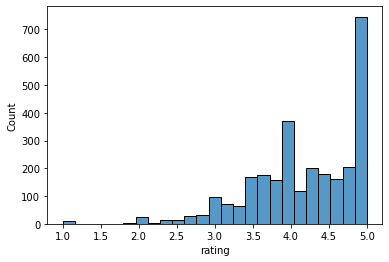

In [14]:
sns.histplot(data=recipes, x='rating')

In [15]:
recipes[recipes['rating'] >= 4.75]   # more than 800 recipes had a rating of more than 4.75

,Unnamed: 0,dishtitle,ingredients,instructions,published,rating,ratings_count,url
2,2,Aquavit Toddy,"['1 star anise pod', '½ teaspoon green cardamo...","Cook star anise, cardamom, and black peppercor...",2014-12-01,4.80,9,https://www.bonappetit.com/recipe/aquavit-toddy
10,10,Boerewors,"['1 3-lb. skinless', ' boneless pork shoulder ...","Chill all grinder parts, including die with ¼”...",2014-07-01,5.00,1,https://www.bonappetit.com/recipe/boerewors
18,18,Spiced Molasses Cookies,"['1¼ cups all-purpose flour', '½ cup whole whe...","Whisk all-purpose flour, whole wheat flour, ba...",2017-12-01,5.00,4,https://www.bonappetit.com/recipe/spiced-molas...
23,23,Bistek with Onion and Bay Leaves,"['2 1-inch-thick boneless rib-eye steaks', ' e...",Slice steaks in half lengthwise. Following nat...,2017-12-01,5.00,1,https://www.bonappetit.com/recipe/bistek-with-...
26,26,"Fettuccine with Crab, Crème Fraîche, Lemon, an...","['1 tablespoon extra-virgin olive oil', '1 tab...",Heat oil and butter in a medium skillet over m...,2017-12-01,5.00,1,https://www.bonappetit.com/recipe/fettuccine-w...
...,...,...,...,...,...,...,...,...
3845,3845,Lemon-Herb Mayonnaise,"['1 garlic clove', ' finely grated', '1 cup ma...","Stir garlic, mayonnaise, herbs, lemon zest, an...",2016-06-01,5.00,1,https://www.bonappetit.com/recipe/lemon-herb-m...
3847,3847,Summer Rolls,"['1 teaspoon sugar', '1 tablespoon fresh lime ...",Stir sugar and 1 Tbsp. warm water in a small b...,2016-06-01,5.00,1,https://www.bonappetit.com/recipe/summer-rolls
3852,3852,Pasta with Shrimp and San Marzano Tomatoes,"['2 pounds medium shell-on shrimp', '1 tablesp...","Shell and devein shrimp, reserving shells. Cut...",2016-06-01,5.00,1,https://www.bonappetit.com/recipe/pasta-with-s...
3853,3853,Sweet and Spicy Bacon Kebabs with Scallion-Gin...,"['6 scallions', ' thinly sliced', '1 serrano c...","Toss scallions, chile, lime juice, oil, ginger...",2016-06-01,5.00,2,https://www.bonappetit.com/recipe/sweet-spicy-...


#### Conclusion

It seems that the recipes from this website are well liked, and thus suitable for our use

### Text Pre-Processing

In [16]:
def title_parser(title):
    
    '''
    Represent unidecode data as ASCII
    '''
    
    title = unidecode.unidecode(title)
    
    return title

Our ingredient parser is one of our most important functions. We first have a list of words that we don't want to be included in our ingredients list, as they are either not ingredients or they contain words that are not a bit basic and not specific enough for our list. 

In [17]:
def ingredient_parser(ingreds):
    measures = ['teaspoon', 't', 'tsp.', 'tablespoon', 'T', 'tbl.', 'tb', 'tbsp.', 'fluid ounce', 'fl oz', 'gill', 
                'cup', 'c', 'pint', 'p', 'pt', 'fl pt', 'quart', 'q', 'qt', 'fl qt', 'gallon', 'g', 'gal', 'ml', 
                'milliliter', 'millilitre', 'cc', 'mL', 'l', 'liter', 'litre', 'L', 'dl', 'deciliter', 'decilitre', 
                'dL', 'bulb', 'level', 'heaped', 'rounded', 'whole', 'pinch', 'medium', 'slice', 'pound', 'lb', '#', 
                'ounce', 'oz', 'mg', 'milligram', 'milligramme', 'g', 'gram', 'gramme', 'kg', 'kilogram', 'kilogramme', 
                'x', 'of', 'mm', 'millimetre', 'millimeter', 'cm', 'centimeter', 'centimetre', 'm', 'meter', 'metre', 
                'inch', 'in', 'milli', 'centi', 'deci', 'hecto', 'kilo']
                
    food_stops = ['fresh', 'oil', 'a', 'red', 'bunch', 'and', 'clove', 'or', 'leaf', 'chilli', 'large', 'extra', 'sprig', 
                   'ground', 'handful', 'free', 'small', 'pepper', 'virgin', 'range', 'from', 'dried', 'sustainable', 'black', 
                   'peeled', 'higher', 'welfare', 'seed', 'for', 'finely', 'freshly', 'sea', 'quality', 'white', 'ripe', 'few', 
                   'piece', 'source', 'to', 'organic', 'flat', 'smoked', 'ginger', 'sliced', 'green', 'picked', 'the', 'stick', 
                   'plain', 'plus', 'mixed', 'mint', 'bay', 'basil', 'your', 'cumin', 'optional', 'fennel', 'serve', 'mustard', 
                   'unsalted', 'baby', 'paprika', 'fat', 'ask', 'natural', 'skin', 'roughly', 'into', 'such', 'cut', 'good', 
                   'brown', 'grated', 'trimmed', 'oregano', 'powder', 'yellow', 'dusting', 'knob', 'frozen', 'on', 'deseeded', 
                   'low', 'runny', 'balsamic', 'cooked', 'streaky', 'nutmeg', 'sage', 'rasher', 'zest', 'pin', 'groundnut', 
                   'breadcrumb', 'turmeric', 'halved', 'grating', 'stalk', 'light', 'tinned', 'dry', 'soft', 'rocket', 'bone', 
                   'colour', 'washed', 'skinless', 'leftover', 'splash', 'removed', 'dijon', 'thick', 'big', 'hot', 'drained', 
                   'sized', 'chestnut', 'watercress', 'fishmonger', 'english', 'dill', 'caper', 'raw', 'worcestershire', 'flake', 
                   'cider', 'cayenne', 'tbsp', 'leg', 'pine', 'wild', 'if', 'fine', 'herb', 'almond', 'shoulder', 'cube', 'dressing', 
                   'with', 'chunk', 'spice', 'thumb', 'garam', 'new', 'little', 'punnet', 'peppercorn', 'shelled', 'saffron', 'other', 
                   'chopped', 'salt', 'olive', 'taste', 'can', 'sauce', 'water', 'diced', 'package', 'italian', 'shredded', 'divided', 
                   'parsley', 'vinegar', 'all', 'purpose', 'crushed', 'juice', 'more', 'coriander', 'bell', 'needed', 'thinly', 'boneless', 
                   'half', 'thyme', 'cubed', 'cinnamon', 'cilantro', 'jar', 'seasoning', 'rosemary', 'extract', 'sweet', 'baking', 'beaten', 
                   'heavy', 'seeded', 'tin', 'vanilla', 'uncooked', 'crumb', 'style', 'thin', 'nut', 'coarsely', 'spring', 'chili', 
                   'cornstarch', 'strip', 'cardamom', 'rinsed', 'honey', 'cherry', 'root', 'quartered', 'head', 'softened', 'container', 
                   'crumbled', 'frying', 'lean', 'cooking', 'roasted', 'warm', 'whipping', 'thawed', 'corn', 'pitted', 'sun', 'kosher', 
                   'bite', 'toasted', 'lasagna', 'split', 'melted', 'degree', 'lengthwise', 'romano', 'packed', 'pod', 'anchovy', 'rom', 
                   'prepared', 'juiced', 'fluid', 'floret', 'room', 'active', 'seasoned', 'mix', 'deveined', 'lightly', 'anise', 'thai', 
                   'size', 'unsweetened', 'torn', 'wedge', 'sour', 'basmati', 'marinara', 'dark', 'temperature', 'garnish', 'bouillon', 
                   'loaf', 'shell', 'reggiano', 'canola', 'parmigiano', 'round', 'canned', 'ghee', 'crust', 'long', 'broken', 'ketchup', 
                   'bulk', 'cleaned', 'condensed', 'sherry', 'provolone', 'cold', 'soda', 'cottage', 'spray', 'tamarind', 'pecorino', 
                   'shortening', 'part', 'bottle', 'sodium', 'cocoa', 'grain', 'french', 'roast', 'stem', 'link', 'firm', 'asafoetida', 
                   'mild', 'dash', 'boiling']
   
    if isinstance(ingreds, list):
        ingredients = ingreds
    else:
        ingredients = ast.literal_eval(ingreds)
        
    translator = str.maketrans('', '', string.punctuation)
    lemmatizer = WordNetLemmatizer()
    ingred_list = []
    
    for i in ingredients:
        i.translate(translator)
        items = re.split(' |-', i)   # split hyphens and spaces
        items = [word for word in items if word.isalpha()]   # get rid of non alphabet letters
        items = [word.lower() for word in items]  # lowercase
        items = [unidecode.unidecode(word) for word in items] # remove accents
        items = [lemmatizer.lemmatize(word) for word in items]   # lemmatize
        items = [word for word in items if word not in measures]  # remove measures
        items = [word for word in items if word not in food_stops]  # remove food stops

        if items:
            ingred_list.append(" ".join(items)) 
            
    ingred_list = " ".join(ingred_list)
    
    return ingred_list
        
                  

In [18]:
def ingredient_parser_final(ingredient):
    
    if isinstance(ingredient, list):
        ingredients = ingredient
    else:
        ingredients = ast.literal_eval(ingredient)
        
    ingredients = ', '.join(ingredients)
    ingredients = unidecode.unidecode(ingredients)
    
    return ingredients

Let's use our ingredients parser on our ingredients. We'll store this data into a new column

In [19]:
recipes['ingredients_parsed'] = recipes['ingredients'].apply(lambda x: ingredient_parser(x))

In [20]:
recipes.head()    # our ingredients parsed is on the right over there

,Unnamed: 0,dishtitle,ingredients,instructions,published,rating,ratings_count,url,ingredients_parsed
0,0,"Fish Pie with Potatoes, Leeks, Zucchini, and T...","['1½ pounds russet potatoes (about 3 medium)',...",Preheat oven to 350°. Cook potatoes in a large...,2015-02-01,3.60,14,https://www.bonappetit.com/recipe/fish-pie-wit...,russet potato butter leek pale only cream zucc...
1,1,Trout Roe and Turnip Toast,"['Dark rye bread', 'Cream cheese', 'Trout roe'...",Spread toasted dark rye bread with cream chees...,2015-01-01,3.00,4,https://www.bonappetit.com/recipe/trout-roe-an...,rye bread cream cheese trout roe turnip radish...
2,2,Aquavit Toddy,"['1 star anise pod', '½ teaspoon green cardamo...","Cook star anise, cardamom, and black peppercor...",2014-12-01,4.80,9,https://www.bonappetit.com/recipe/aquavit-toddy,star sugar unfiltered apple apple aquavit gamm...
3,3,Almond-Barley Porridge with Fruit Compote,"['½ cup sugar', '¾ cup dried cherries', ' divi...","Bring sugar, ½ cup cherries, and 1½ cups water...",2014-12-01,4.30,16,https://www.bonappetit.com/recipe/almond-barle...,sugar blanched milk pearl barley bean chocolat...
4,4,Thai Celery Salad with Peanuts,"['3 tablespoons vegetable oil', '2 tablespoons...","Whisk together oil, lime juice, and fish sauce...",2014-09-01,4.31,56,https://www.bonappetit.com/recipe/thai-celery-...,vegetable lime fish celery diagonal scallion c...


### TFIDF Vectorizer

Term Frequency, Inverse Document Frequency <br>

We'll use this to extract features from our parsed ingredients 

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

recipes['ingredients_parsed'] = recipes.ingredients_parsed.values.astype('U')

In [22]:
# feature extraction

tfidf = TfidfVectorizer()
tfidf.fit(recipes['ingredients_parsed'])
tfidf_recipe = tfidf.transform(recipes['ingredients_parsed'])

In [23]:
tfidf_recipe        # this is stored as a sparse matrix

<3857x2384 sparse matrix of type '<class 'numpy.float64'>'
	with 48393 stored elements in Compressed Sparse Row format>

In [24]:
with open('tfidf.pkl', 'wb') as f:      # dump our model as a pickle
    pickle.dump(tfidf, f)

In [25]:
with open('tfidf_recipe.pkl', 'wb') as f:       # dump our encoded features as a pickle also
    pickle.dump(tfidf_recipe, f)

In [26]:
def get_recommendations(N, scores):
    
    '''
    Gathers the pertinent information for the recommended recipes
    
    :params N: The number of recommendations
    :params scores: The cosine similarity scores
    '''
    
    top = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:N]
    recommendation = pd.DataFrame(columns = ['recipe', 'ingredients', 'score', 'url'])
    
    count = 0
    
    for i in top:
        recommendation.at[count, 'recipe'] = title_parser(recipes['dishtitle'][i])
        recommendation.at[count, 'ingredients'] = ingredient_parser_final(recipes['ingredients'][i])
        recommendation.at[count, 'url'] = recipes['url'][i]
        recommendation.at[count, 'score'] = '{:.3f}'.format(float(scores[i]))
        count += 1
    
    return recommendation

In [27]:
def RecSys(ingredients, N=5):
    
    '''
    Takes in a list of ingredients and returns top 5 recipes
    '''
    
    with open('tfidf.pkl', 'rb') as f:
        tfidf = pickle.load(f)
        
    with open('tfidf_recipe.pkl', 'rb') as f:
        tfidf_encodings = pickle.load(f)
        
    try:
        ingredients_parsed = ingredient_parser(ingredients)
    except:
        ingredients_parsed = ingredient_parser([ingredients])
        
    ingredients_tfidf = tfidf.transform([ingredients_parsed])
    
    cos_sim = map(lambda x: cosine_similarity(ingredients_tfidf, x), tfidf_encodings)
    
    scores = list(cos_sim)
    
    recommendations = get_recommendations(N, scores)
    
    return recommendations

In [28]:
test_ingreds = ['strawberry', 'ice cream']
recs = RecSys(test_ingreds)

In [29]:
print(recs.score)

0    0.797
1    0.649
2    0.559
3    0.543
4    0.520
Name: score, dtype: object


In [30]:
recs

,recipe,ingredients,score,url
0,Neo-Neapolitan Bombe,"2 pints coconut ice cream (not dairy-free), 2 ...",0.797,https://www.bonappetit.com/recipe/neo-neapolit...
1,Roasted Buttered Cherries,"3 cups halved pitted sour cherries, 4 tablespo...",0.649,https://www.bonappetit.com/recipe/roasted-butt...
2,Basically Strawberry Shortcakes,"2 cups all-purpose flour, plus more for surfa...",0.559,https://www.bonappetit.com/recipe/basically-st...
3,Coconut-Strawberry Ice Cream Pie,"1 cup unsweetened shredded coconut, 6 oz. grah...",0.543,https://www.bonappetit.com/recipe/coconut-stra...
4,Salted Pistachio Crumbles With Berries and Ice...,"1/2 cup (60 g) raw pistachios, 1 cup (125 g)...",0.520,https://www.bonappetit.com/recipe/salted-pista...


## Streamlit 

In [33]:
import streamlit as st
import streamlit.components.v1 as stc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def main():
    st.title('Recipe Recommendation App')
    menu = ['Home', 'Recommend', 'About']
    choice = st.sidebar.selectbox('Menu', menu)
    
    if choice == 'Home':
        st.subheader('Home')
    elif choice == 'Recommend':
        st.subheader('Recommend Recipes')
    else:
        st.subheader('About')
        st.text('Build with Streamlit and pandas')

        if '__name__' == '__main__':
    main()